In [1]:
import math
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import breathDetectionFunctions as bd   
% matplotlib inline

In [2]:
# read in dataset
dset = pd.read_csv('TYME_H - 2016_11_2 (17.12pm to 18.33pm).txt',sep = ' ') # read in dataset

In [3]:
#Variables
f=10

print("Sampling rate: " + str(f) + "Hz")
print(str(dset.shape[0]) + " Data points")
print(str(dset.shape[0]/(f*60)) + " Minutes")

Sampling rate: 10Hz
50207 Data points
83.67833333333333 Minutes


In [4]:
# pick subsample (just for visualization purposes, so I am not plotting the whole dataset each time.)
d = pd.DataFrame(data = dset[0:dset.shape[0]]) #Picking all the data
#d = pd.DataFrame(data = dset[0:25000]) #Select which data points; used to be [:8000]
d.index = pd.RangeIndex(start = 0, stop = len(d), step = 1) # to measure time from beginning of sub-sample
d.columns = ['chest','belly','ax','ay','az','gx','gy','gz']
d['time'] = d.index*(1/f) # add timestamp assuming 10 samples / second

d = d.reset_index()

# smoothen sample: subsecond dynamics are removed using exponentially weighted moving average
d['cesm'] = d['chest'].rolling(window = 100,center = False).apply(lambda x: bd.expSmoothen(x,f)) # smoothen
#d['besm'] = d['belly'].rolling(window = 100,center = False).apply(lambda x: bd.expSmoothen(x,f)) # smoothen

# calculate [6] second moving average and subtract it from smoothened signal to remove long-term drift 
d['cmav'] = d['chest'].rolling(window = 7*f,center = False).mean() - 0 # slight offset because breaths are held for some time.
d['del'] = d['cesm'] - d['cmav']

# calculate [6] second moving average and subtract it from smoothened signal to remove long-term drift 
#d['bmav'] = d['belly'].rolling(window = 7*f,center = False).mean() - 0 # slight offset because breaths are held for some time.
#d['bdel'] = d['besm'] - d['bmav']

# identify breath phase: distinguishes between above-average and below-average expansion of the sensor. 
d['ph1'] = d['del'].apply(bd.phase) # function: +1 if positive, -1 if negative
#d['ph2'] = d['bdel'].apply(bd.phase) # function: +1 if positive, -1 if negative

# take derivative of phase curve: +1 where rise, -1 where fall
d['ph1_slp'] = 0.025*d['ph1'].rolling(window = 2, center = False).apply(bd.slp)
#d['ph2_slp'] = 0.025*d['ph2'].rolling(window = 2, center = False).apply(bd.slp)

# store vector with the last [-x:] rise times,
d['riseTimes'] = d['time'].apply(lambda x: d['time'][0:int(x/(1/f))][d['ph1_slp'][0:int(x/(1/f))]>0].values[-10:])
#d['briseTimes'] = d['time'].apply(lambda x: d['time'][0:int(x/(1/f))][d['ph2_slp'][0:int(x/(1/f))]>0].values[-10:])

# store vector with the last [-x:] fall times
d['fallTimes'] = d['time'].apply(lambda x: d['time'][0:int(x/(1/f))][d['ph1_slp'][0:int(x/(1/f))]<0].values[-10:])
#d['bfallTimes'] = d['time'].apply(lambda x: d['time'][0:int(x/(1/f))][d['ph2_slp'][0:int(x/(1/f))]<0].values[-10:])

# calculate last [19] breath times based on rise times
d['rbtime'] = d['riseTimes'].apply(lambda x: x[1:] - x[:-1])
# calculate last [19] breath times based on fall times
d['fbtime'] = d['fallTimes'].apply(lambda x: x[1:] - x[:-1])
# calculate last [19] breath times based on rise times
#d['brbtime'] = d['briseTimes'].apply(lambda x: x[1:] - x[:-1])
# calculate last [19] breath times based on fall times
#d['bfbtime'] = d['bfallTimes'].apply(lambda x: x[1:] - x[:-1])

# replace empty entries with NaN
def repNan(x):
    if len(x) == 0:
        return [np.nan]
    else:
        return x
    
# filter all breath measurements that are unrealistically short or long
def filterBreaths(x):
    return [d for d in x if d > 1.5 and d < 24]
    
d['rbtime'] = d['rbtime'].apply(lambda x: filterBreaths(x)).apply(repNan)
d['fbtime'] = d['fbtime'].apply(lambda x: filterBreaths(x)).apply(repNan)
#d['brbtime'] = d['brbtime'].apply(lambda x: filterBreaths(x)).apply(repNan)
#d['bfbtime'] = d['bfbtime'].apply(lambda x: filterBreaths(x)).apply(repNan)

#def lastEntry(x):
#    if len(x) > 0:
#        return x[-1]
#    else:
#        return np.nan
    
d['rlast'] = d['rbtime'].apply(lambda x: x[-1])
d['flast'] = d['fbtime'].apply(lambda x: x[-1])
#d['brlast'] = d['brbtime'].apply(lambda x: x[-1])
#d['bflast'] = d['bfbtime'].apply(lambda x: x[-1])

# calculate averaged breath time 
d['rmav'] = d['rlast'].rolling(window = 30*f, center = False).mean().apply(lambda x: 60/x)
d['fmav'] = d['flast'].rolling(window = 30*f, center = False).mean().apply(lambda x: 60/x) # calculate 30s average breath rate
d['rfmav'] = (d['rmav']+ d['fmav'])/2

#d['brmav'] = d['brlast'].rolling(window = 30*f, center = False).mean().apply(lambda x: 60/x)
#d['bfmav'] = d['bflast'].rolling(window = 30*f, center = False).mean().apply(lambda x: 60/x) # calculate 30s average breath rate
#d['brfmav'] = (d['brmav']+ d['bfmav'])/2

# movement data acceleration
d['acc'] = (d['ax'].multiply(d['ax']) + d['ay'].multiply(d['ay']) + d['az'].multiply(d['az'])).apply(np.sqrt)

# movement data angular velocity
d['gyr'] = (d['gx'].multiply(d['gx']) + d['gy'].multiply(d['gy']) + d['gz'].multiply(d['gz'])).apply(np.sqrt)

Autonomic: 40.8066666667 minutes
Autonomic light: 38.24 minutes
Normal breathing: 3.525 minutes
Cardio: 0.105 minutes
Total: 82.6766666667 minutes


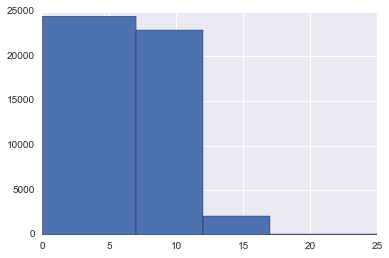

In [5]:
#Calculate the occurrence of each breathing type
occurrence=d['rfmav'].hist(bins=[0,7,12,17,25])
def get_hist(ax):
    n=[]
    for rect in ax.patches:
        ((x0, y0), (x1, y1)) = rect.get_bbox().get_points()
        n.append(y1-y0)
    return n
n = get_hist(occurrence)

b1=n[0]/(60*f)
b2=n[1]/(60*f)
b3=n[2]/(60*f)
b4=n[3]/(60*f)

print("Autonomic: " + str(b1) + " minutes")
print("Autonomic light: " + str(b2) + " minutes")
print("Normal breathing: " + str(b3) + " minutes")
print("Cardio: " + str(b4) + " minutes")
print("Total: " + str(b1+b2+b3+b4) + " minutes")

In [6]:
f=d

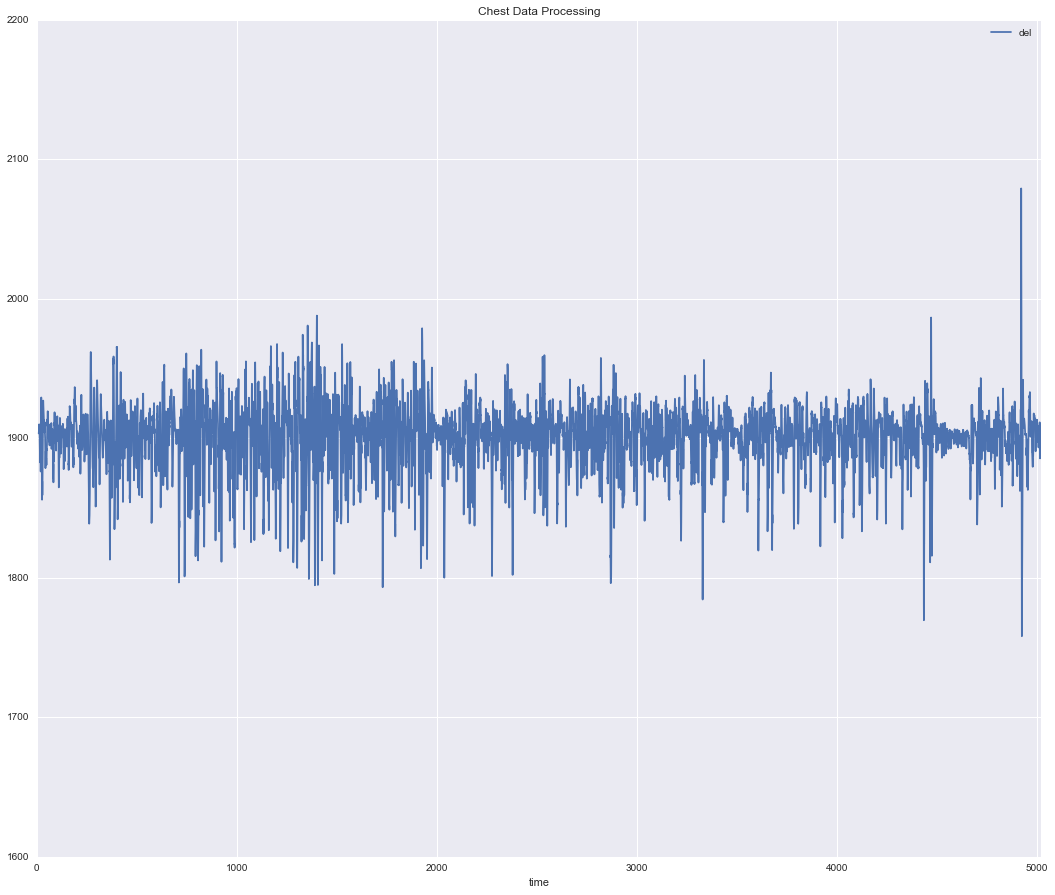

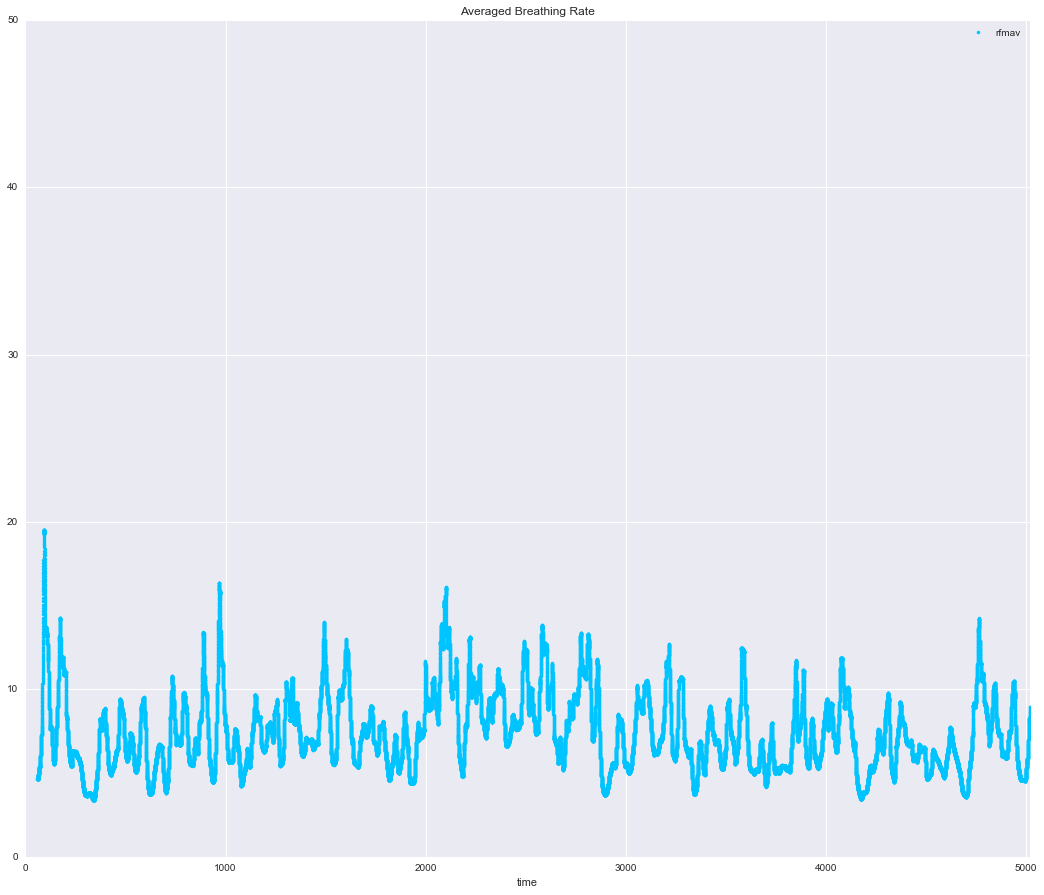

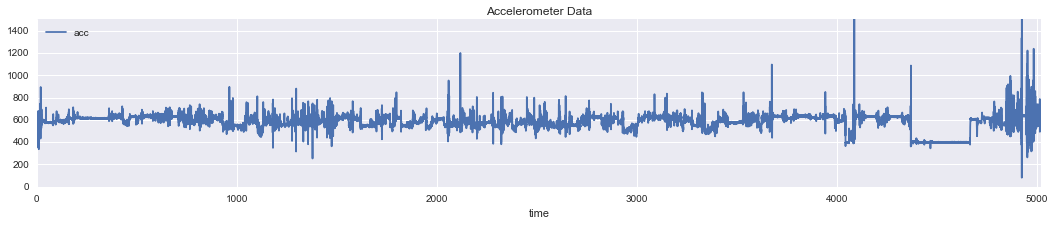

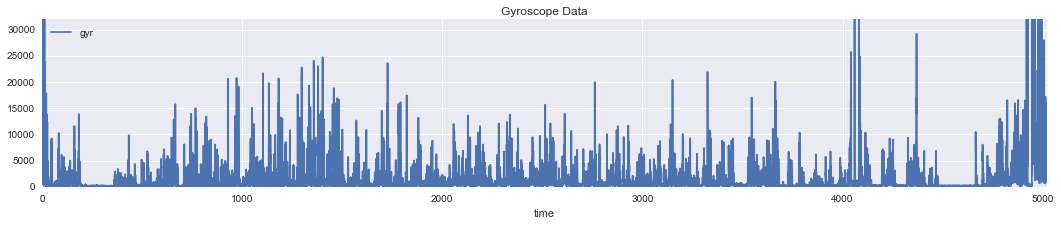

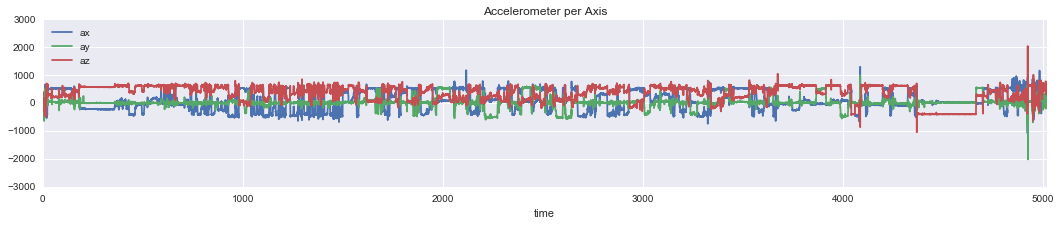

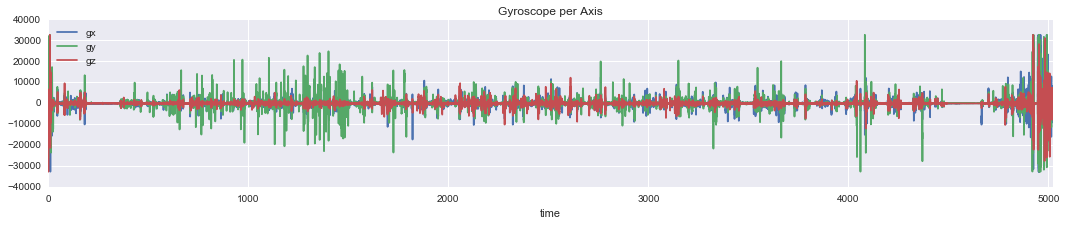

In [7]:
# this is just for plotting data 
g = d
g['cesm'] = f['cesm'] - 500
g['cmav'] = f['cmav'] - 500
g['del'] = f['del'] + 1900
g['b1'] = 1900
g['ph1'] = 100*f['ph1'] + 2800
#g['b2'] = 1600
#g['ph2'] = 100*f['ph2'] + 2200
#g.plot(x = 'time',y = ['chest','belly','cesm','cmav','del','b1','ph1','b2'],figsize = (18,15),title = 'Chest Data Processing')
g.plot(style=['-'],x = 'time',y = ['del'],figsize = (18,15), ylim = (1600,2200), title = 'Chest Data Processing')
#g.plot(x = 'time',y = ['chest','belly','ph1','ph2'],figsize = (18,15),title = 'Breathing Raw Data')
#d.plot(x = 'time',y = ['rlast','flast'], figsize = (18,3), title = 'Length of last detected breath, based on successive rise (r) and fall (f) times.')
d.plot(style=['.'], x = 'time',y = ['rfmav'], color = '#00C4FF', ylim = (0,50), figsize = (18,15), title = 'Averaged Breathing Rate')
d.plot(x = 'time',y = 'acc',figsize = (18,3), ylim=(0,1500), title = 'Accelerometer Data')
d.plot(x = 'time',y = 'gyr',figsize = (18,3), ylim=(0,32000), title = 'Gyroscope Data')
d.plot(x = 'time',y = ['ax','ay','az'],figsize = (18,3), title = 'Accelerometer per Axis')
d.plot(x = 'time',y = ['gx','gy','gz'],figsize = (18,3), title = 'Gyroscope per Axis')

Note that all moving averages are calculated using only data available at the time, which causes the corresponding curves to lag behind (compare moving averages of breath times to real-time breath times above). 

In [8]:
print(d[::1000]) # every thousandth line of the processed dataset

       index  chest  belly   ax   ay   az     gx    gy    gz    time  ...   \
0          0   1803   1689 -527  112  286     96  -746 -4093     0.0  ...    
1000    1000   1798   1689  361   35  500   -720   -49   121   100.0  ...    
2000    2000   1901   1682 -200   -1  583   -204   -51  -141   200.0  ...    
3000    3000   1870   1658 -223    7  574    -96   -62  -126   300.0  ...    
4000    4000   1828   1596 -205    7  592     14   -75  -174   400.0  ...    
5000    5000   1831   1602 -392   12  432   -186  -195    23   500.0  ...    
6000    6000   1741   1613  -17   92  625   -357   113  -184   600.0  ...    
7000    7000   1857   1689  -64   -1  627    -88   -73  -134   700.0  ...    
8000    8000   1809   1609 -201  -13  588    -62   -17  -240   800.0  ...    
9000    9000   1842   1695 -237   12  561   -265   -89    -2   900.0  ...    
10000  10000   1741   1591  537   54   54   -178   -18  -208  1000.0  ...    
11000  11000   1758   1535   67   15  664   -606  1200    -9  11

In [9]:
d.head(6000)

,index,chest,belly,ax,ay,az,gx,gy,gz,time,...,rbtime,fbtime,rlast,flast,rmav,fmav,rfmav,acc,gyr,b1
0,0,1803,1689,-527,112,286,96,-746,-4093,0.0,...,[nan],[nan],NaN,NaN,NaN,NaN,NaN,609.974590,4161.535894,1900
1,1,1807,1689,-404,44,294,3118,-9438,-7898,0.1,...,[nan],[nan],NaN,NaN,NaN,NaN,NaN,501.585486,12695.517792,1900
2,2,1814,1691,-465,-44,350,7328,-2332,-4140,0.2,...,[nan],[nan],NaN,NaN,NaN,NaN,NaN,583.661717,8733.693835,1900
3,3,1813,1692,-372,-100,374,3272,-5283,-12472,0.3,...,[nan],[nan],NaN,NaN,NaN,NaN,NaN,536.898501,13934.376807,1900
4,4,1813,1693,-210,-263,323,-5075,-6087,-18306,0.4,...,[nan],[nan],NaN,NaN,NaN,NaN,NaN,466.474008,19947.852767,1900
5,5,1813,1694,-360,-265,406,2668,8684,-18923,0.5,...,[nan],[nan],NaN,NaN,NaN,NaN,NaN,603.871675,20990.712446,1900
6,6,1814,1693,-273,-320,368,2775,10449,2810,0.6,...,[nan],[nan],NaN,NaN,NaN,NaN,NaN,558.885498,11170.421926,1900
7,7,1814,1697,-356,-328,284,-7423,13163,-10577,0.7,...,[nan],[nan],NaN,NaN,NaN,NaN,NaN,561.227227,18445.553041,1900
8,8,1816,1696,-168,-607,3,-31625,-7330,-32768,0.8,...,[nan],[nan],NaN,NaN,NaN,NaN,NaN,629.826960,46126.037647,1900
9,9,1816,1699,-97,-449,92,-24842,-26304,-19548,0.9,...,[nan],[nan],NaN,NaN,NaN,NaN,NaN,468.480523,41123.590359,1900
